In [9]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import multiprocessing
import seaborn as sns
import pickle

from gensim.corpora.dictionary import Dictionary

# Label dimensionality reduction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import FeatureAgglomeration
from gensim.models import LdaModel, LsiModel, RpModel
from scipy.sparse import csr_matrix

# Feature generation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Modelling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
# Based on this post: https://stackoverflow.com/questions/42819460/what-is-the-difference-between-onevsrestclassifier-and-multioutputclassifier-in
# it appears that OneVsRestClassifier works the same as MultiOutputClassifier in our case with binary Multi-Label classification.

# from sklearn.multioutput import MultiOutputClassifier # For doing One-vs-Rest by training K number of binary classifiers where K = n_classes
# # See docs: https://scikit-learn.org/stable/modules/multiclass.html

# Deep Learning
import keras
import numpy as np
import tensorflow as tf
from keras import Model
from keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping


# Model Tuning
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import jaccard_score, hamming_loss, zero_one_loss, multilabel_confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer

In [10]:
with open('gensim_dictionary.pickle', 'rb') as f:
    dictionary = pickle.load(f)
    
with open('tokenized_nostops_descriptions.pickle', 'rb') as f:
    tokenized_descriptions = pickle.load(f)

In [11]:
df = pd.read_pickle('../data/df_cats.pickle')
df.head(1)

,id,name,description,categories_Abstract Strategy,categories_Action / Dexterity,categories_Adventure,categories_Age of Reason,categories_American Civil War,categories_American Indian Wars,categories_American Revolutionary War,...,categories_Transportation,categories_Travel,categories_Trivia,categories_Video Game Theme,categories_Vietnam War,categories_Wargame,categories_Word Game,categories_World War I,categories_World War II,categories_Zombies
0,174430,Gloomhaven,Gloomhaven is a game of Euro-inspired tactica...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
raw_features = df.description
labels = df.iloc[:, 3:]
print(raw_features.shape)
print(labels.shape)

(17146,)
(17146, 83)


# Label dimensionality reduction

In [13]:
cos_sim = cosine_similarity(labels.T); cos_sim.shape

(83, 83)

(array([4.788e+03, 9.180e+02, 4.200e+02, 1.960e+02, 1.700e+02, 8.000e+01,
        5.400e+01, 2.800e+01, 3.400e+01, 2.800e+01, 1.000e+01, 2.000e+01,
        2.000e+01, 6.000e+00, 6.000e+00, 6.000e+00, 1.200e+01, 0.000e+00,
        2.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.300e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects

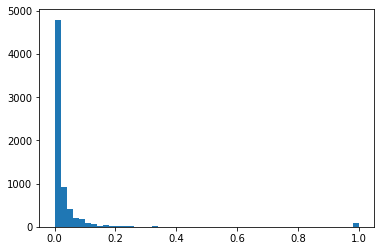

In [14]:
plt.hist(cos_sim.flatten(), bins=50)

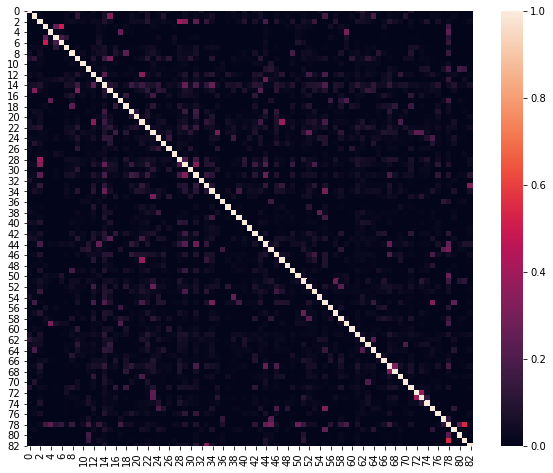

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(cos_sim)

### Feature Agglomeration


<div class="alert alert-warning">NOTE: This is problematic, because we lose the binary nature of the data => only relevant for DL approach? </div>


In [16]:
featAgg = FeatureAgglomeration(n_clusters=20
                               , affinity = 'cosine'
                               , linkage = 'average')

featAgg.fit(labels)

FeatureAgglomeration(affinity='cosine', linkage='average', n_clusters=20)

In [17]:
agg_labels = featAgg.transform(labels)

In [18]:
agg_labels.shape

(17146, 20)

In [19]:
agg_labels[:10,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.29411765,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.2       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.16666667, 0.05882353, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.2       , 0.25      , 0.        , 0.        , 0.11764706,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.08333333, 0.        , 0.25      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.125     , 0.23529412,
        0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.16666667, 0.        , 0.        , 0.11764706,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.16666667, 0.       

In [20]:
labels_restored = featAgg.inverse_transform(agg_labels)

In [21]:
labels_restored.shape

(17146, 83)

In [22]:
labels_restored

array([[0.        , 0.        , 0.29411765, ..., 0.        , 0.        ,
        0.29411765],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05882353, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.05882353, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11764706, 0.11764706, ..., 0.        , 0.        ,
        0.11764706],
       [0.5       , 0.05882353, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## LDA (Latent Dirichlet Allocation)

In [23]:
# convert to sparse matrix (CSR method)
S = csr_matrix(labels.values); S

<17146x83 sparse matrix of type '<class 'numpy.uint8'>'
	with 45335 stored elements in Compressed Sparse Row format>

In [24]:
# The data needs to be in a specific format for LdaModel
# More specifically, the format is list[list[(int,int)]] where the first int is the index of the category column and the second one is always 1
# For example, here are the first 3 rows of transformed data:
# [[(2, 1), (28, 1), (29, 1), (31, 1), (44, 1)],
#  [(26, 1), (41, 1)],
#  [(14, 1), (18, 1), (23, 1)],
# Below I put the data in that format

sparse_labels = []

for sparse_row in S:
    
    new_row = []
    
    loc_of_1s = np.where(sparse_row.todense()==1)[1]
    
    for loc_of_1 in loc_of_1s:
        
        new_row.append((loc_of_1, 1))
        
    sparse_labels.append(new_row)

In [25]:
lda = LdaModel(sparse_labels
               , num_topics=20) # This sets the dimensionality we want

vector = lda[sparse_labels]

In [26]:
unpacked_topics = []
for topic in vector:
    unpacked_topics.append(topic)

In [27]:
len(unpacked_topics)

17146

In [28]:
max_prob = []

for unpacked_topic_indx in range(len(unpacked_topics)): #
    max_prob.append(sum([tpl[1] for tpl in unpacked_topics[unpacked_topic_indx]]))

(array([3.330e+02, 6.970e+02, 3.010e+02, 1.320e+02, 7.800e+01, 1.800e+01,
        5.000e+00, 2.000e+00, 0.000e+00, 1.558e+04]),
 array([0.84166461, 0.85749816, 0.87333171, 0.88916525, 0.9049988 ,
        0.92083235, 0.93666589, 0.95249944, 0.96833299, 0.98416653,
        1.00000008]),
 <a list of 10 Patch objects>)

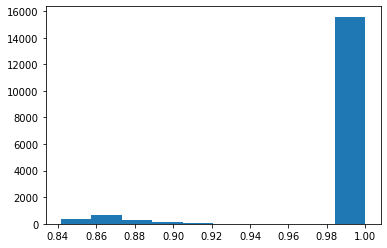

In [29]:
plt.hist(max_prob)


<div class="alert alert-success">NOTE: Apparently most games have 1 high probability latent topic. This is great! </div>


In [30]:
# Below we transform the LDA labels into a numpy array with 0s & 1s

# Initializing new LDA labels
lda_labels = np.zeros((labels.shape[0], 20)); 
print(lda_labels.shape)

for unpacked_topic_idx in range(len(unpacked_topics)):
    
    mean_value = np.mean([tpl[1] for tpl in unpacked_topics[unpacked_topic_idx]])
    
    for tpl in unpacked_topics[unpacked_topic_idx]:
        if tpl[1] >= mean_value:
            lda_labels[unpacked_topic_idx, tpl[0]] = 1
    

(17146, 20)


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 6 Text yticklabel objects>)

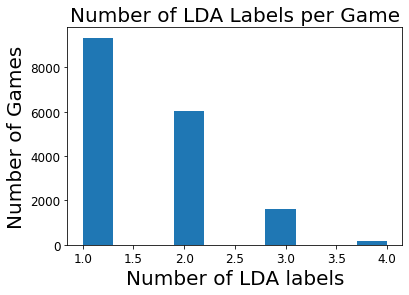

In [34]:
# It looks like most of the games now have 1, or 2 LDA labels
plt.hist(np.sum(lda_labels, axis=1))
plt.title('Number of LDA Labels per Game', fontsize=20)
plt.ylabel('Number of Games', fontsize=20)
plt.xlabel('Number of LDA labels', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## LSA(Latent Semantic Analysis)

In [176]:
lsi = LsiModel(sparse_labels
               , num_topics=20) # This sets the dimensionality we want

vector = lsi[sparse_labels]

In [177]:
unpacked_topics = []
for topic in vector:
    unpacked_topics.append(topic)

<BarContainer object of 20 artists>

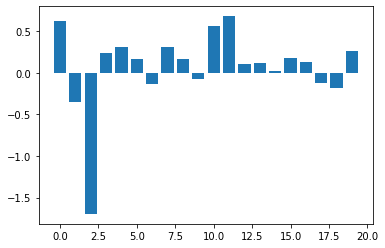

In [183]:
x = [tpl[0] for tpl in unpacked_topics[0]]
y = [tpl[1] for tpl in unpacked_topics[0]]

plt.bar(x=x, height=y)

<BarContainer object of 20 artists>

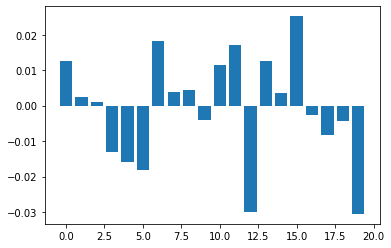

In [184]:
x = [tpl[0] for tpl in unpacked_topics[1]]
y = [tpl[1] for tpl in unpacked_topics[1]]

plt.bar(x=x, height=y)

<BarContainer object of 20 artists>

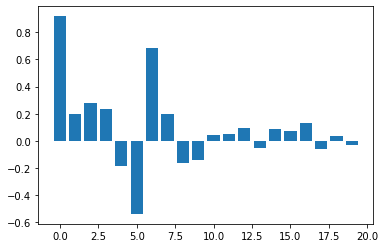

In [185]:
x = [tpl[0] for tpl in unpacked_topics[2]]
y = [tpl[1] for tpl in unpacked_topics[2]]

plt.bar(x=x, height=y)

<BarContainer object of 20 artists>

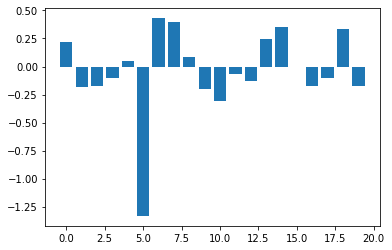

In [186]:
x = [tpl[0] for tpl in unpacked_topics[3]]
y = [tpl[1] for tpl in unpacked_topics[3]]

plt.bar(x=x, height=y)

In [180]:
unpacked_topics[0]

[(0, 0.6170664252322854),
 (1, -0.34703665326972744),
 (2, -1.6970238806495104),
 (3, 0.24334837581802027),
 (4, 0.307759472150887),
 (5, 0.16271267066459447),
 (6, -0.13236919368204517),
 (7, 0.31380301230132035),
 (8, 0.16112068911853822),
 (9, -0.07043144921385759),
 (10, 0.5572507253847757),
 (11, 0.6797817258165434),
 (12, 0.10267965461551251),
 (13, 0.12321747888782322),
 (14, 0.016518782709005447),
 (15, 0.17531544642139568),
 (16, 0.13171302944945665),
 (17, -0.12441682530268527),
 (18, -0.1819793109309722),
 (19, 0.2622614239908212)]


<div class="alert alert-warning"> BELOW CODE IS NOT WORKING, NEED TO FIGURE OUT HEURISTIC FOR TRANSFORMING TO ONE-HOT ENCODING </div>


In [178]:
len(unpacked_topics)

17146

In [147]:
max_prob = []

for unpacked_topic_indx in range(len(unpacked_topics)): #
    max_prob.append(sum([tpl[1] for tpl in unpacked_topics[unpacked_topic_indx]]))

(array([3.410e+02, 7.020e+02, 2.830e+02, 1.420e+02, 7.800e+01, 1.300e+01,
        5.000e+00, 2.000e+00, 0.000e+00, 1.558e+04]),
 array([0.8416658 , 0.85749923, 0.87333266, 0.88916609, 0.90499952,
        0.92083294, 0.93666637, 0.9524998 , 0.96833323, 0.98416666,
        1.00000008]),
 <a list of 10 Patch objects>)

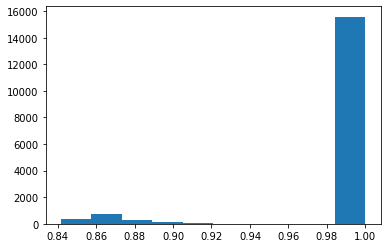

In [150]:
plt.hist(max_prob)

In [167]:
# Below we transform the LDA labels into a numpy array with 0s & 1s

# Initializing new LDA labels
lsi_labels = np.zeros((labels.shape[0], 20)); 
print(lsi_labels.shape)

for unpacked_topic_idx in range(len(unpacked_topics)):
    
    mean_value = np.mean([tpl[1] for tpl in unpacked_topics[unpacked_topic_idx]])
    
    for tpl in unpacked_topics[unpacked_topic_idx]:
        if tpl[1] >= mean_value:
            lsi_labels[unpacked_topic_idx, tpl[0]] = 1
    

(array([8498., 6610., 1868.,  170.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <a list of 4 Patch objects>)

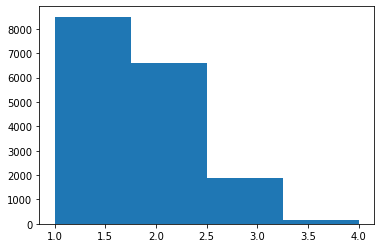

In [175]:
# It looks like most of the games now have 1, or 2 LDA labels
plt.hist(np.sum(lda_labels, axis=1), bins=4)


<div class="alert alert-warning"> ABOVE CODE IS NOT WORKING, NEED TO FIGURE OUT HEURISTIC FOR TRANSFORMING TO ONE-HOT ENCODING </div>


## Preparing features & labels

In [13]:
# Need the tokenized descriptions as entire strings, not lists of tokens
def stringify(description):
    
    return " ".join(description)

pool = multiprocessing.Pool(multiprocessing.cpu_count()) # 

preprocessed_description_strings = pool.map(stringify, tokenized_descriptions)

pool.close()

In [14]:
# Example cleaned string
preprocessed_description_strings[0]

'gloomhaven game euro inspired tactical combat persistent world shifting motives players take role wandering adventurer special set skills reasons traveling dark corner world players must work together necessity clear menacing dungeons forgotten ruins process enhance abilities experience loot discover new locations explore plunder expand ever branching story fueled decisions make game persistent changing world ideally played many game sessions scenario players make decisions determine story continues kind like choose adventure book playing scenario cooperative affair players fight automated monsters using innovative card system determine order play player turn turn player chooses two cards play hand number top card determines initiative round card also top bottom power player turn initiative order determine whether use top power one card bottom power vice versa players must careful though time permanently lose cards hands take long clear dungeon may end exhausted forced retreat'

In [19]:
# BOW unigrams
count_vectorizer = CountVectorizer(lowercase=False, ngram_range =(1,1), max_df = .5, min_df = 100)
unigram_bow_corpus = count_vectorizer.fit_transform(preprocessed_description_strings)
unigram_bow_corpus

<17146x2261 sparse matrix of type '<class 'numpy.int64'>'
	with 911393 stored elements in Compressed Sparse Row format>

In [20]:
# BOW unigrams & bigrams
count_vectorizer = CountVectorizer(lowercase=False, ngram_range =(1,2), max_df = .5, min_df = 100)
uni_and_bigram_bow_corpus = count_vectorizer.fit_transform(preprocessed_description_strings)
uni_and_bigram_bow_corpus

<17146x2773 sparse matrix of type '<class 'numpy.int64'>'
	with 1026904 stored elements in Compressed Sparse Row format>

In [21]:
# TFIDF unigrams
tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range =(1,1), max_df = .5, min_df = 100)
unigram_tfidf_corpus = tfidf_vectorizer.fit_transform(preprocessed_description_strings)
unigram_tfidf_corpus

<17146x2261 sparse matrix of type '<class 'numpy.float64'>'
	with 911393 stored elements in Compressed Sparse Row format>

In [22]:
# TFIDF unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range =(1,2), max_df = .5, min_df = 100)
uni_and_bigram_tfidf_corpus = tfidf_vectorizer.fit_transform(preprocessed_description_strings)
uni_and_bigram_tfidf_corpus

<17146x2773 sparse matrix of type '<class 'numpy.float64'>'
	with 1026904 stored elements in Compressed Sparse Row format>

## Train_Test Split


<div class="alert alert-warning">NOTE: CURRENTLY JUST EXPERIMENTING WITH unigram_bow_corpus </div>


In [122]:
indices = range(df.shape[0])

train_indices, test_indices = train_test_split(indices, random_state=42, test_size=0.2, shuffle=True)

X_train = unigram_bow_corpus[train_indices]
y_train = labels.iloc[train_indices, :]

X_test = unigram_bow_corpus[test_indices]
y_test = labels.iloc[test_indices, :]

print('TRAINING DATA')
print('FEATURES ', X_train.shape)
print('LABELS ', y_train.shape)

print('TEST DATA')
print('FEATURES ',X_test.shape)
print('LABELS ', y_test.shape)

TRAINING DATA
FEATURES  (13716, 2261)
LABELS  (13716, 83)
TEST DATA
FEATURES  (3430, 2261)
LABELS  (3430, 83)


# Modelling

## RANDOM - FORESTS

In [169]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


<div class="alert alert-success">NOTE: Much faster with n_jobs = -1 </div>


In [171]:
%%time
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

CPU times: user 1min 8s, sys: 1.12 s, total: 1min 9s
Wall time: 1min 9s


RandomForestClassifier(random_state=42)

In [172]:
%%time
rf = RandomForestClassifier(random_state=42
                            , n_jobs = -1)
rf.fit(X_train, y_train)

CPU times: user 2min 23s, sys: 4.14 s, total: 2min 27s
Wall time: 14.5 s


RandomForestClassifier(n_jobs=-1, random_state=42)

## RandomCV Search

In [202]:
rf_dict = {'n_estimators': [70, 100, 150, 200]
           , 'max_depth': [None, 2,5,10]
           , 'ccp_alpha': [0, .01, .1]
          }

In [203]:
param_grid = ParameterGrid(rf_dict);param_grid

In [204]:
rf = RandomForestClassifier(random_state=42
                            , n_jobs = -1
                            , verbose = 1
                           )

# Converts the metric function - jaccard_score - into something that RandomizedSearchCV can use to evaluate a given model
jaccard_scorer = make_scorer(jaccard_score, average='micro')

best_rf = RandomizedSearchCV(rf
                             , rf_dict
                             , n_iter=10
                             , n_jobs = -1
                             , cv=3
                             , scoring=jaccard_scorer)



## BOW - UNIGRAM CORPUS

In [205]:
best_rf.fit(unigram_bow_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   39.9s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [0, 0.01, 0.1],
                                        'max_depth': [None, 2, 5, 10],
                                        'n_estimators': [70, 100, 150, 200]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [210]:
# Best Random Forest Parameters
best_rf.best_params_ # {'n_estimators': 150, 'max_depth': None, 'ccp_alpha': 0}

{'n_estimators': 150, 'max_depth': None, 'ccp_alpha': 0}

In [220]:
# Top score
best_rf.best_score_

0.1917938689619385

### The different parameter values that were tried and the corresponding results

In [216]:
# These are the average scores over the 10 iterations (average over the 3 CV folds within a given iteration)
best_rf.cv_results_['mean_test_score']

array([0.00252974, 0.        , 0.        , 0.1915055 , 0.        ,
       0.02180457, 0.        , 0.19179387, 0.02196535, 0.        ])

In [218]:
best_rf.cv_results_['param_max_depth']

masked_array(data=[2, None, 10, None, 2, 5, 10, None, 5, None],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

In [223]:
best_rf.cv_results_['param_n_estimators']

masked_array(data=[150, 70, 70, 200, 100, 150, 100, 150, 100, 200],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

In [224]:
best_rf.cv_results_['param_ccp_alpha']

masked_array(data=[0, 0.1, 0.01, 0, 0.01, 0, 0.1, 0, 0, 0.1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

## BOW - UNIGRAM + BIGRAM

In [225]:
best_rf.fit(uni_and_bigram_bow_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.3s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [0, 0.01, 0.1],
                                        'max_depth': [None, 2, 5, 10],
                                        'n_estimators': [70, 100, 150, 200]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [228]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 150, 'max_depth': 10, 'ccp_alpha': 0}

In [227]:
# Top score
best_rf.best_score_

0.06529360773901653

## TFIDF - Unigram_tfidf_corpus

In [229]:
best_rf.fit(unigram_tfidf_corpus , labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   57.0s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [0, 0.01, 0.1],
                                        'max_depth': [None, 2, 5, 10],
                                        'n_estimators': [70, 100, 150, 200]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [230]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 150, 'max_depth': None, 'ccp_alpha': 0}

In [231]:
# Top score
best_rf.best_score_

0.19125782241746278

## TFIDF - UNIGRAM + BIGRAM

In [232]:
best_rf.fit(uni_and_bigram_tfidf_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [0, 0.01, 0.1],
                                        'max_depth': [None, 2, 5, 10],
                                        'n_estimators': [70, 100, 150, 200]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [233]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 100, 'max_depth': 10, 'ccp_alpha': 0}

In [234]:
# Top score
best_rf.best_score_

0.06368836514927444


<div class="alert alert-success">It appears that max_depth = None with ccp_alpha=0 is best, but could potentially do with more n_estimators </div>


### Checking just n_estimators

In [235]:
rf_dict = {'n_estimators': [130, 150, 170, 200, 230]
          }

In [236]:
rf = RandomForestClassifier(random_state=42
                            , n_jobs = -1
                            , verbose = 1
                           )

# Converts the metric function - jaccard_score - into something that RandomizedSearchCV can use to evaluate a given model
jaccard_scorer = make_scorer(jaccard_score, average='micro')

best_rf = RandomizedSearchCV(rf
                             , rf_dict
                             , n_iter=5
                             , n_jobs = -1
                             , cv=3
                             , scoring=jaccard_scorer)



## BOW - UNIGRAM CORPUS

In [237]:
best_rf.fit(unigram_bow_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   50.2s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'n_estimators': [130, 150, 170, 200,
                                                         230]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [238]:
# Best Random Forest Parameters
best_rf.best_params_ 

{'n_estimators': 150}

In [239]:
# Top score
best_rf.best_score_

0.1917938689619385

## BOW - UNIGRAM + BIGRAM

In [240]:
best_rf.fit(uni_and_bigram_bow_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'n_estimators': [130, 150, 170, 200,
                                                         230]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [241]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 230}

In [242]:
# Top score
best_rf.best_score_

0.19338024490508335

## TFIDF - Unigram_tfidf_corpus

In [243]:
best_rf.fit(unigram_tfidf_corpus , labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.2s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'n_estimators': [130, 150, 170, 200,
                                                         230]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [244]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 150}

In [245]:
# Top score
best_rf.best_score_

0.19125782241746278

## TFIDF - UNIGRAM + BIGRAM

In [246]:
best_rf.fit(uni_and_bigram_tfidf_corpus, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'n_estimators': [130, 150, 170, 200,
                                                         230]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [247]:
# Best Random Forest Parameters
best_rf.best_params_

{'n_estimators': 230}

In [248]:
# Top score
best_rf.best_score_

0.19480018667613816


<div class="alert alert-success">It appears that n_estimators=150 is best for the unigram corpuses, but n_estimators=230 (or potentially larger) for the uni+bigram corpuses </div>



<div class="alert alert-success">Also, the Jaccard Score appears to be a bit better on the uni+bigram corpus, but only a little bit </div>


# Logistic Regression

### Single Estimator in OVR

In [12]:
# Single iteration
lr = LogisticRegression(max_iter=1000)
ovr = OneVsRestClassifier(lr).fit(X_train, y_train)

In [13]:
ovr.score(X_test, y_test)

0.13294460641399417

In [14]:
y_pred_lr_ovr = ovr.predict(X_test)

In [15]:
jaccard_score(y_test, y_pred_lr_ovr, average='micro')

0.35095874491574663

### OVR inside RandomizedSearchCV

In [23]:
lr_dict = {'estimator__C': [2,1,.5,.1,.01,0]} # For clarification why there is "estimator__", see this SO post: https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

lr = LogisticRegression( #n_jobs = -1
                        random_state = 42
                        , verbose = 0
                        , max_iter = 1000)

ovr = OneVsRestClassifier(lr) #, n_jobs = -1

# Converts the metric function - jaccard_score - into something that RandomizedSearchCV can use to evaluate a given model
jaccard_scorer = make_scorer(jaccard_score, average='micro')

best_lr_ovr = RandomizedSearchCV(ovr
                             , lr_dict
                             , n_iter=5
#                              , n_jobs = -1
                             , cv=3
                             , scoring=jaccard_scorer)

#### BOW UNIGRAM CORPUS

In [24]:
best_lr_ovr.fit(unigram_bow_corpus, labels)

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py", line 245, in fit
    for i, column in enumerate(columns))
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 765, 

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                              random_state=42)),
                   n_iter=5,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [27]:
best_lr_ovr.best_params_

{'estimator__C': 0.5}

In [29]:
best_lr_ovr.best_score_

0.3358777980831083

#### BOW UNI+BIGRAM CORPUS

In [30]:
best_lr_ovr.fit(uni_and_bigram_bow_corpus, labels)

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py", line 245, in fit
    for i, column in enumerate(columns))
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 765, 

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                              random_state=42)),
                   n_iter=5,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [31]:
best_lr_ovr.best_params_

{'estimator__C': 0.5}

In [32]:
best_lr_ovr.best_score_

0.34166566869407355

#### TFIDF UNIGRAM CORPUS

In [33]:
best_lr_ovr.fit(unigram_tfidf_corpus, labels)

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py", line 245, in fit
    for i, column in enumerate(columns))
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 765, 

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                              random_state=42)),
                   n_iter=5,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [34]:
best_lr_ovr.best_params_

{'estimator__C': 1}

In [35]:
best_lr_ovr.best_score_

0.2677553984119441

#### TFIDF UNI+BIGRAM CORPUS

In [36]:
best_lr_ovr.fit(uni_and_bigram_tfidf_corpus, labels)

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                              random_state=42)),
                   n_iter=5,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [37]:
best_lr_ovr.best_params_

{'estimator__C': 2}

In [38]:
best_lr_ovr.best_score_

0.30901622431582276


<div class="alert alert-success">Best performing appears to be BOW Uni+Bigram corpus with C=0.5 </div>


# LinearSVC

### Single Estimator in OVR

In [43]:
# Single iteration
svm = LinearSVC(random_state=42
                , max_iter = 50000
                , verbose=1)
ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [44]:
ovr.score(X_test, y_test)

0.0793002915451895

In [45]:
y_pred_svm_ovr = ovr.predict(X_test)

In [46]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.30012686118715365

### RandomizedSearchCV

In [51]:
svm_dict = {'estimator__C': [2,1,.5,.1,.01,0]} # For clarification why there is "estimator__", see this SO post: https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

svm = LinearSVC(#n_jobs = -1
                random_state = 42
                , verbose = 1
                , max_iter = 50000)

ovr = OneVsRestClassifier(svm, n_jobs = -1) #

# Converts the metric function - jaccard_score - into something that RandomizedSearchCV can use to evaluate a given model
jaccard_scorer = make_scorer(jaccard_score, average='micro')

best_svm_ovr = RandomizedSearchCV(ovr
                             , svm_dict
                             , n_iter=5
                             , n_jobs = -1
                             , cv=3
                             , scoring=jaccard_scorer)

### BOW UNIGRAM CORPUS

In [52]:
best_svm_ovr.fit(unigram_bow_corpus, labels)

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LinearSVC(max_iter=50000,
                                                                     random_state=42,
                                                                     verbose=1),
                                                 n_jobs=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [53]:
best_svm_ovr.best_params_

{'estimator__C': 0.01}

In [54]:
best_svm_ovr.best_score_

0.33347006693731074

### BOW UNI+BIGRAM CORPUS

In [55]:
best_svm_ovr.fit(uni_and_bigram_bow_corpus, labels)

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LinearSVC(max_iter=50000,
                                                                     random_state=42,
                                                                     verbose=1),
                                                 n_jobs=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [56]:
best_svm_ovr.best_params_

{'estimator__C': 0.1}

In [57]:
best_svm_ovr.best_score_

0.3285471551655335

### TFIDF UNIGRAM CORPUS

In [58]:
best_svm_ovr.fit(unigram_tfidf_corpus, labels)

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LinearSVC(max_iter=50000,
                                                                     random_state=42,
                                                                     verbose=1),
                                                 n_jobs=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [59]:
best_svm_ovr.best_params_

{'estimator__C': 1}

In [60]:
best_svm_ovr.best_score_

0.35970803324115347

### TFIDF UNI+BIGRAM CORPUS

In [61]:
best_svm_ovr.fit(uni_and_bigram_tfidf_corpus, labels)

RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=LinearSVC(max_iter=50000,
                                                                     random_state=42,
                                                                     verbose=1),
                                                 n_jobs=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'estimator__C': [2, 1, 0.5, 0.1, 0.01,
                                                         0]},
                   scoring=make_scorer(jaccard_score, average=micro))

In [62]:
best_svm_ovr.best_params_

{'estimator__C': 1}

In [63]:
best_svm_ovr.best_score_

0.36267199408424333


<div class="alert alert-success">Best performing appears to be TFIDF Uni+Bigram corpus with C=1 </div>



<div class="alert alert-success">Also nice that LinearSVC appears to train fairly fast</div>


# SVC - Radial Basis

### Single Estimator in OVR

In [65]:
# Single iteration
svm = SVC(random_state=42
          , max_iter = -1 # -1 for no limit.
          , verbose=1
          , kernel = 'rbf'
           )
ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [66]:
ovr.score(X_test, y_test)

0.14110787172011663

In [67]:
y_pred_svm_ovr = ovr.predict(X_test)

In [68]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.2650083963056255


<div class="alert alert-warning">Trains quite slow and performs worse</div>


## Two best models
### LogRegon on BOW Uni+Bigram Corpus w/ C=.5 => Jacc Score = .3416
### LinearSVC on TFIDF Uni+Bigram Corpus w/ C=1 => Jacc Score = .36267

### Checking performance on test set - Logistic Regression

In [125]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_bow_corpus[train_indices]
y_train = labels.iloc[train_indices, :]

X_test = uni_and_bigram_bow_corpus[test_indices]
y_test = labels.iloc[test_indices, :]


lr = LogisticRegression(max_iter=1000, C=.5)
ovr = OneVsRestClassifier(lr).fit(X_train, y_train)

In [126]:
print("TRAINING DATA ", X_train.shape)
print("TRAINING DATA ", y_train.shape)
print("TEST DATA ", X_test.shape)
print("TEST DATA ", y_test.shape)

TRAINING DATA  (13716, 2773)
TRAINING DATA  (13716, 83)
TEST DATA  (3430, 2773)
TEST DATA  (3430, 83)


In [127]:
ovr.score(X_test, y_test)

0.15160349854227406

In [128]:
y_pred_lr_ovr = ovr.predict(X_test)

In [49]:
jaccard_score(y_test, y_pred_lr_ovr, average='micro')

0.3654808959156785

In [50]:
hamming_loss(y_test, y_pred_lr_ovr) # Fraction of labels incorrectly predicted; Lower is better

0.02537496926481436

In [51]:
zero_one_loss(y_test, y_pred_lr_ovr)

0.8483965014577259

In [52]:
y_prob_lr_ovr = ovr.predict_proba(X_test);

In [53]:
roc_auc_score(y_test, y_prob_lr_ovr, average='micro')

0.914257006644184

In [54]:
precision = precision_score(y_test, y_pred_lr_ovr, average='micro')
recall = recall_score(y_test, y_pred_lr_ovr, average='micro')
f1 = f1_score(y_test, y_pred_lr_ovr, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6505, Recall: 0.4548, F1-measure: 0.5353


### Checking Performance on Test Set - Linear SVC

In [151]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_tfidf_corpus[train_indices]
y_train = labels.iloc[train_indices, :]

X_test = uni_and_bigram_tfidf_corpus[test_indices]
y_test = labels.iloc[test_indices, :]


svm = LinearSVC(random_state=42
                , max_iter = 50000
                , verbose=1
                , C=1)

ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [152]:
ovr.score(X_test, y_test)

0.18658892128279883

In [153]:
y_pred_svm_ovr = ovr.predict(X_test)

In [154]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.38786254427108263

In [155]:
hamming_loss(y_test, y_pred_svm_ovr) # Fraction of labels incorrectly predicted; Lower is better

0.022463029962415258

In [156]:
zero_one_loss(y_test, y_pred_svm_ovr)

0.8134110787172012

In [63]:
precision = precision_score(y_test, y_pred_svm_ovr, average='micro')
recall = recall_score(y_test, y_pred_svm_ovr, average='micro')
f1 = f1_score(y_test, y_pred_svm_ovr, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.7574, Recall: 0.4429, F1-measure: 0.5589



<div class="alert alert-success">It appears that LinearSVC performs slightly better than LogReg on the Test data</div>

Although it's worth pointing out that maybe it's not a fair comparison, because it's not really the same data (one is BOW, the other TFIDF), but CrossValidation suggested those are the best corresponding. I went back and tried giving LogReg the TFIDF corpus and it did much worse! So verified :)


### Checking Performance on Test Set - Linear SVC - WITH BALANCED DATA

In [132]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_tfidf_corpus[train_indices]
y_train = labels.iloc[train_indices, :]

X_test = uni_and_bigram_tfidf_corpus[test_indices]
y_test = labels.iloc[test_indices, :]


svm = LinearSVC(random_state=42
                , max_iter = 50000
                , verbose=1
                , C=1
                , class_weight = 'balanced')

ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [133]:
ovr.score(X_test, y_test)

0.0912536443148688

In [134]:
y_pred_svm_ovr = ovr.predict(X_test)

In [135]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.3546023794614903

In [136]:
hamming_loss(y_test, y_pred_svm_ovr) # Fraction of labels incorrectly predicted; Lower is better

0.03620429238821174

In [137]:
zero_one_loss(y_test, y_pred_svm_ovr)

0.9087463556851312

In [138]:
precision = precision_score(y_test, y_pred_svm_ovr, average='micro')
recall = recall_score(y_test, y_pred_svm_ovr, average='micro')
f1 = f1_score(y_test, y_pred_svm_ovr, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.4536, Recall: 0.6190, F1-measure: 0.5236



<div class="alert alert-warning">Performs a bit worse overall on F1, BUT DOES MUCH BETTER ON RECALL!</div>


### Testing the best LogReg model on the LDA labels

In [250]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_bow_corpus[train_indices]
y_train = lda_labels[train_indices, :]

X_test = uni_and_bigram_bow_corpus[test_indices]
y_test = lda_labels[test_indices, :]


lr = LogisticRegression(max_iter=1000, C=.5)
ovr = OneVsRestClassifier(lr).fit(X_train, y_train)

In [251]:
ovr.score(X_test, y_test)

0.2087463556851312

In [252]:
y_pred_lr_ovr = ovr.predict(X_test)

In [253]:
jaccard_score(y_test, y_pred_lr_ovr, average='micro')

0.3024501271923952

In [254]:
hamming_loss(y_test, y_pred_lr_ovr)

0.07594752186588921

In [255]:
zero_one_loss(y_test, y_pred_lr_ovr)

0.7912536443148688

### Testing the best LinearSVC on the LDA labels

In [256]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_tfidf_corpus[train_indices]
y_train = lda_labels[train_indices, :]

X_test = uni_and_bigram_tfidf_corpus[test_indices]
y_test = lda_labels[test_indices, :]


svm = LinearSVC(random_state=42
                , max_iter = 50000
                , verbose=1
                , C=1)

ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [257]:
ovr.score(X_test, y_test)

0.2588921282798834

In [258]:
y_pred_svm_ovr = ovr.predict(X_test)

In [259]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.3269373791462145

In [262]:
hamming_loss(y_test, y_pred_svm_ovr) # Fraction of labels incorrectly predicted; Lower is better

0.06596209912536444

In [261]:
zero_one_loss(y_test, y_pred_svm_ovr)

0.7411078717201166


<div class="alert alert-warning">Unfortunately, both models appear to be performing worse in terms of Jaccard Score, Hamming Loss, and Exact Match Rate</div>

They are, however, performing better on zero_one_loss. Oh well.


### Testing the best LinearSVC on the LDA labels - WITH BALANCED DATA

In [92]:
# Best Logistic Regression Performance on best data and parameters
X_train = uni_and_bigram_tfidf_corpus[train_indices]
y_train = lda_labels[train_indices, :]

X_test = uni_and_bigram_tfidf_corpus[test_indices]
y_test = lda_labels[test_indices, :]


svm = LinearSVC(random_state=42
                , max_iter = 50000
                , verbose=1
                , C=1
                , class_weight = 'balanced')

ovr = OneVsRestClassifier(svm).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [93]:
ovr.score(X_test, y_test)

0.1274052478134111

In [94]:
y_pred_svm_ovr = ovr.predict(X_test)

In [95]:
jaccard_score(y_test, y_pred_svm_ovr, average='micro')

0.29479402444545044

In [96]:
hamming_loss(y_test, y_pred_svm_ovr) # Fraction of labels incorrectly predicted; Lower is better

0.11354227405247813

In [97]:
zero_one_loss(y_test, y_pred_svm_ovr)

0.8725947521865889

In [98]:
precision = precision_score(y_test, y_pred_svm_ovr, average='micro')
recall = recall_score(y_test, y_pred_svm_ovr, average='micro')
f1 = f1_score(y_test, y_pred_svm_ovr, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.3647, Recall: 0.6059, F1-measure: 0.4554



<div class="alert alert-warning">Unfortunately, both models appear to be performing worse in terms of Jaccard Score, Hamming Loss, and Exact Match Rate</div>

Again, Recall improves a lot when we use balanced data, but overall performance is not as good in terms of F1 score


# Some Deep Learning

In [279]:
# Will be using this preprocessed data: preprocessed_description_strings

In [101]:
# Transforming to Pandas Series so index slicing works
preprocessed_descriptions = pd.Series(preprocessed_description_strings)

In [102]:
train_texts = preprocessed_descriptions[train_indices]
y_train = labels.iloc[train_indices, :]

test_texts = preprocessed_descriptions[test_indices]
y_test = labels.iloc[test_indices, :]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
max_length = max([len(s.split()) for s in train_texts])

In [103]:
encoded_train_texts = tokenizer.texts_to_sequences(train_texts)    
X_train = pad_sequences(encoded_train_texts, maxlen=max_length, padding='post')

encoded_test_texts = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(encoded_test_texts, maxlen=max_length, padding='post')

In [71]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

53868


In [72]:
X_test

array([[    6,     1,   356, ...,     0,     0,     0],
       [38737, 50189, 44577, ...,     0,     0,     0],
       [  139,   106,  9602, ...,     0,     0,     0],
       ...,
       [   20,     6,  2881, ...,     0,     0,     0],
       [ 2883,  1751,     1, ...,     0,     0,     0],
       [  572,   648,  3923, ...,     0,     0,     0]], dtype=int32)

## Vanilla, fully connected

In [392]:
model = Sequential()

model.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(200))
model.add(Dense(83, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose=1)
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy: %f' % acc)
print('Test loss: %f' % loss)

Epoch 1/10
429/429 [==============================] - 1s 2ms/step - loss: 32.1274 - accuracy: 0.0534
Epoch 2/10
429/429 [==============================] - 1s 1ms/step - loss: 1.3510 - accuracy: 0.0946
Epoch 3/10
429/429 [==============================] - 1s 1ms/step - loss: 0.7287 - accuracy: 0.1810
Epoch 4/10
429/429 [==============================] - 1s 1ms/step - loss: 0.4178 - accuracy: 0.1969
Epoch 5/10
429/429 [==============================] - 1s 1ms/step - loss: 0.3132 - accuracy: 0.2022
Epoch 6/10
429/429 [==============================] - 1s 1ms/step - loss: 0.1552 - accuracy: 0.2064
Epoch 7/10
429/429 [==============================] - 1s 1ms/step - loss: 0.1288 - accuracy: 0.2082
Epoch 8/10
429/429 [==============================] - 1s 1ms/step - loss: 0.1274 - accuracy: 0.2087
Epoch 9/10
429/429 [==============================] - 1s 1ms/step - loss: 0.1253 - accuracy: 0.2087
Epoch 10/10
108/108 [==============================] - 0s 730us/step - loss: 0.2777 - accuracy: 0.2

## Convolutional Layer Added

In [73]:
def build_cnn_classifier(vocab_size: int, max_length: int, emb_size=256, num_filters=32, kernel_size=8) -> Sequential:
    model = Sequential()
    model.add(Embedding(vocab_size, emb_size, input_length=max_length)) # max_len x emb_size
    
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')) # , input_shape=(vocab_size,)
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
#     model.add(Dropout(rate=0.3))
#     model.add(Dense(1000, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(200, activation='relu')) # <-- Tried values: 10, 100, 200
    model.add(Dropout(rate=0.3))
    model.add(Dense(100, activation='relu')) # 
    model.add(Dropout(rate=0.3))
    model.add(Dense(100, activation='relu')) # 
    model.add(Dense(83, activation='sigmoid')) #  <--- Number here should equal the number of outputs i.e. the number of categories 
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [74]:
model_cnn = build_cnn_classifier(vocab_size, max_length)

# Define a callback to monitor val_loss
monitor_val_loss = EarlyStopping(monitor='val_loss', # <-- Switched to val_loss, because what does accuracy even mean when my true labels are 1-hot encoded and the output of the network are probabilities i.e. floats
                       patience=2)

h_callback = model_cnn.fit(X_train, y_train
                      , validation_data=(X_test, y_test)
                      , callbacks = [monitor_val_loss]
                      , epochs=10 # Tried 10, 15
                      , verbose=1)


loss, acc = model_cnn.evaluate(X_test, y_test, verbose=1)
print('Test accuracy: %f' % acc)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 999, 256)          13790208  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 992, 32)           65568     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 496, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15872)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               7936500   
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)              

----------------
results for CNN: (I think that the loss is not relevant, because of the different architecture?
- Dense = 10 epochs = 10 ==> loss: 0.1174 - accuracy: 0.2656l - AUC: 0.7493
- Dense = 100 epochs = 10 ==> loss: 0.1784 - accuracy: 0.3478 - AUC:  0.8445
- Dense = 100 epochs = 15 ==> loss: 0.2429 - accuracy: 0.3359 - AUC:  0.8372 # I think it begins overfitting after ~10 epochs
- Dense = 100 Dense =100 epochs = 10 ==> loss: 0.1517 - accuracy: 0.3397 - AUC:  0.8634
- Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) ==> loss: 0.0898 - accuracy: 0.3478 - AUC:  0.8634
- Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) ==> loss: 0.0900 - accuracy: 0.3501 - AUC:  0.8588
- Dropout(.3) > Dense(200) > Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) ==> loss: 0.0892 - accuracy: 0.3507 - AUC:  0.8684
- Dropout(.3) > Dense(500) > Dropout(.3) > Dense(200) > Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) ==> loss: 0.0903 - accuracy: 0.3306 - AUC: 0.8684; Precision: 0.5230, Recall: 0.4316, F1-measure: 0.4730  
- Embedding_size = 256 ; Dropout(.3) > Dense(500) > Dropout(.3) > Dense(200) > Dropout(.3) > Dense(100) > Dropout(.3) > Dense(100) ==> loss: 0.0899 - accuracy: 0.3507 - AUC:  0.8548; Precision: 0.5296, Recall: 0.4324, F1-measure: 0.4761

In [104]:
predictions_cnn = model_cnn.predict(X_test)

In [105]:
print('Test AUC: ', round(roc_auc_score(y_test, predictions_cnn), 4))

Test AUC:  0.8548


In [106]:

# thresholds=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, .1, .11, .12, .13, .14, .15, .16, .17, .18, .19]
thresholds=[0.1,0.2,.25,0.3, .35,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions_cnn.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    
    print("THRESHOLD VALUE: ", val)
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

THRESHOLD VALUE:  0.1
Micro-average quality numbers
Precision: 0.2545, Recall: 0.6686, F1-measure: 0.3687
THRESHOLD VALUE:  0.2
Micro-average quality numbers
Precision: 0.4075, Recall: 0.5238, F1-measure: 0.4584
THRESHOLD VALUE:  0.25
Micro-average quality numbers
Precision: 0.4714, Recall: 0.4746, F1-measure: 0.4730
THRESHOLD VALUE:  0.3
Micro-average quality numbers
Precision: 0.5296, Recall: 0.4324, F1-measure: 0.4761
THRESHOLD VALUE:  0.35
Micro-average quality numbers
Precision: 0.5842, Recall: 0.3938, F1-measure: 0.4705
THRESHOLD VALUE:  0.4
Micro-average quality numbers
Precision: 0.6337, Recall: 0.3652, F1-measure: 0.4634
THRESHOLD VALUE:  0.5
Micro-average quality numbers
Precision: 0.7262, Recall: 0.3149, F1-measure: 0.4393
THRESHOLD VALUE:  0.6
Micro-average quality numbers
Precision: 0.7887, Recall: 0.2676, F1-measure: 0.3996
THRESHOLD VALUE:  0.7
Micro-average quality numbers
Precision: 0.8436, Recall: 0.2265, F1-measure: 0.3571
THRESHOLD VALUE:  0.8
Micro-average quality 

best threshold is .3

In [107]:
pred_cnn=predictions_cnn.copy()
  
pred_cnn[pred_cnn>=.3]=1
pred_cnn[pred_cnn<.3]=0

In [108]:
jaccard_score(y_test, pred_cnn, average='micro')

0.31240622285398406

In [109]:
hamming_loss(y_test,  pred_cnn) # Fraction of labels incorrectly predicted; Lower is better

0.030584144156802134

In [110]:
zero_one_loss(y_test,  pred_cnn)

0.8653061224489795

In [111]:
precision = precision_score(y_test, pred_cnn, average='micro')
recall = recall_score(y_test, pred_cnn, average='micro')
f1 = f1_score(y_test, pred_cnn, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.5296, Recall: 0.4324, F1-measure: 0.4761


# CNN with LDA labels

In [145]:
train_texts = preprocessed_descriptions[train_indices]
y_train = lda_labels[train_indices, :]

test_texts = preprocessed_descriptions[test_indices]
y_test = lda_labels[test_indices, :]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
max_length = max([len(s.split()) for s in train_texts])

In [116]:
encoded_train_texts = tokenizer.texts_to_sequences(train_texts)    
X_train = pad_sequences(encoded_train_texts, maxlen=max_length, padding='post')

encoded_test_texts = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(encoded_test_texts, maxlen=max_length, padding='post')

In [117]:
def build_cnn_classifier(vocab_size: int, max_length: int, emb_size=256, num_filters=32, kernel_size=8) -> Sequential:
    model = Sequential()
    model.add(Embedding(vocab_size, emb_size, input_length=max_length)) # max_len x emb_size
    
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')) # , input_shape=(vocab_size,)
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
#     model.add(Dropout(rate=0.3))
#     model.add(Dense(1000, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(200, activation='relu')) # <-- Tried values: 10, 100, 200
    model.add(Dropout(rate=0.3))
    model.add(Dense(100, activation='relu')) # 
    model.add(Dropout(rate=0.3))
    model.add(Dense(100, activation='relu')) # 
    model.add(Dense(20, activation='sigmoid')) #  <--- Number here should equal the number of outputs i.e. the number of categories 
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [118]:
model_cnn = build_cnn_classifier(vocab_size, max_length)

# Define a callback to monitor val_loss
monitor_val_loss = EarlyStopping(monitor='val_loss', # <-- Switched to val_loss, because what does accuracy even mean when my true labels are 1-hot encoded and the output of the network are probabilities i.e. floats
                       patience=2)

h_callback = model_cnn.fit(X_train, y_train
                      , validation_data=(X_test, y_test)
                      , callbacks = [monitor_val_loss]
                      , epochs=10 # Tried 10, 15
                      , verbose=1)


loss, acc = model_cnn.evaluate(X_test, y_test, verbose=1)
print('Test accuracy: %f' % acc)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 999, 256)          13790208  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 992, 32)           65568     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 496, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 15872)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               7936500   
_________________________________________________________________
dropout_18 (Dropout)         (None, 500)              

In [119]:
predictions_cnn = model_cnn.predict(X_test)

In [120]:
print('Test AUC: ', round(roc_auc_score(y_test, predictions_cnn), 4))

Test AUC:  0.8175


In [121]:

# thresholds=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, .1, .11, .12, .13, .14, .15, .16, .17, .18, .19]
thresholds=[0.1,0.2,.25,0.3, .35,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions_cnn.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    
    print("THRESHOLD VALUE: ", val)
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

THRESHOLD VALUE:  0.1
Micro-average quality numbers
Precision: 0.2175, Recall: 0.7183, F1-measure: 0.3339
THRESHOLD VALUE:  0.2
Micro-average quality numbers
Precision: 0.3248, Recall: 0.5329, F1-measure: 0.4036
THRESHOLD VALUE:  0.25
Micro-average quality numbers
Precision: 0.3878, Recall: 0.4555, F1-measure: 0.4190
THRESHOLD VALUE:  0.3
Micro-average quality numbers
Precision: 0.4456, Recall: 0.3984, F1-measure: 0.4207
THRESHOLD VALUE:  0.35
Micro-average quality numbers
Precision: 0.4930, Recall: 0.3603, F1-measure: 0.4163
THRESHOLD VALUE:  0.4
Micro-average quality numbers
Precision: 0.5413, Recall: 0.3277, F1-measure: 0.4083
THRESHOLD VALUE:  0.5
Micro-average quality numbers
Precision: 0.6317, Recall: 0.2767, F1-measure: 0.3848
THRESHOLD VALUE:  0.6
Micro-average quality numbers
Precision: 0.6952, Recall: 0.2389, F1-measure: 0.3556
THRESHOLD VALUE:  0.7
Micro-average quality numbers
Precision: 0.7517, Recall: 0.2045, F1-measure: 0.3215
THRESHOLD VALUE:  0.8
Micro-average quality 

best threshold is .3

In [139]:
pred_cnn=predictions_cnn.copy()
  
pred_cnn[pred_cnn>=.3]=1
pred_cnn[pred_cnn<.3]=0

In [146]:
jaccard_score(y_test, pred_cnn, average='micro')

0.2663597909927843

In [147]:
y_test.shape

(3430, 20)

In [148]:
hamming_loss(y_test,  pred_cnn) # Fraction of labels incorrectly predicted; Lower is better

0.08596209912536443

In [149]:
zero_one_loss(y_test,  pred_cnn)

0.7618075801749271

In [150]:
precision = precision_score(y_test, pred_cnn, average='micro')
recall = recall_score(y_test, pred_cnn, average='micro')
f1 = f1_score(y_test, pred_cnn, average='micro')
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.4456, Recall: 0.3984, F1-measure: 0.4207


# LSTM

In [407]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(83, activation='sigmoid'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 999, 128)          6895104   
_________________________________________________________________
lstm (LSTM)                  (None, 999, 128)          131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 999, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 83)                5395      
Total params: 7,081,491
Trainable params: 7,081,491
Non-trainable params: 0
___________________________________________

In [411]:
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(X_train, y_train
#                     , class_weight='balanced'
                    , epochs=5
                    , batch_size=32
                    , validation_data=(X_test, y_test)
                    , callbacks = [monitor_val_loss]
                    , verbose = 1
                   )

Epoch 1/5
429/429 [==============================] - 434s 1s/step - loss: 0.1322 - val_loss: 0.1244
Epoch 2/5
429/429 [==============================] - 411s 959ms/step - loss: 0.1273 - val_loss: 0.1243
Epoch 3/5
429/429 [==============================] - 428s 998ms/step - loss: 0.1263 - val_loss: 0.1242
Epoch 4/5
429/429 [==============================] - 473s 1s/step - loss: 0.1256 - val_loss: 0.1242
Epoch 5/5
429/429 [==============================] - 456s 1s/step - loss: 0.1255 - val_loss: 0.1242


In [414]:
roc_auc_score(y_test, predictions, average='micro')

0.7782343644851142

Best threshold value is  0.11

In [417]:
predictions=model.predict(X_test)
thresholds=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, .1, .11, .12, .13, .14, .15, .16, .17, .18, .19]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    
    print("THRESHOLD VALUE: ", val)
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

THRESHOLD VALUE:  0.01
Micro-average quality numbers
Precision: 0.0470, Recall: 0.9170, F1-measure: 0.0895
THRESHOLD VALUE:  0.02
Micro-average quality numbers
Precision: 0.0602, Recall: 0.8127, F1-measure: 0.1121
THRESHOLD VALUE:  0.03
Micro-average quality numbers
Precision: 0.0736, Recall: 0.7172, F1-measure: 0.1335
THRESHOLD VALUE:  0.04
Micro-average quality numbers
Precision: 0.0851, Recall: 0.6383, F1-measure: 0.1502
THRESHOLD VALUE:  0.05
Micro-average quality numbers
Precision: 0.0995, Recall: 0.5220, F1-measure: 0.1671
THRESHOLD VALUE:  0.06
Micro-average quality numbers
Precision: 0.1109, Recall: 0.4573, F1-measure: 0.1785
THRESHOLD VALUE:  0.07
Micro-average quality numbers
Precision: 0.1206, Recall: 0.4069, F1-measure: 0.1861
THRESHOLD VALUE:  0.08
Micro-average quality numbers
Precision: 0.1564, Recall: 0.2931, F1-measure: 0.2040
THRESHOLD VALUE:  0.09
Micro-average quality numbers
Precision: 0.1736, Recall: 0.2604, F1-measure: 0.2083
THRESHOLD VALUE:  0.1
Micro-average q

In [413]:
predictions

array([[0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142],
       [0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142],
       [0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142],
       ...,
       [0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142],
       [0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142],
       [0.07365957, 0.04420111, 0.04498366, ..., 0.00941122, 0.05537581,
        0.00921142]], dtype=float32)

# BERT

In [114]:
# import numpy as np
# import pandas as pd
# from sklearn import metrics
# import transformers
# import torch
# from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import BertTokenizer, BertModel, BertConfig

# from torch import cuda
# device = 'cuda' if cuda.is_available() else 'cpu'
# print(device)

# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
#         self.l2 = torch.nn.Dropout(0.3)
#         self.l3 = torch.nn.Linear(768, 83)
    
#     def forward(self, ids, mask, token_type_ids):
#         _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
#         output_2 = self.l2(output_1)
#         output = self.l3(output_2)
#         return output

    
#     torch.load with map_location=torch.device('cpu')
# with open('model.pickle', 'rb') as file:
#     bert = pickle.load(file)

Got this error: RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Not able to load, because model trained on Google Colab with GPU and my laptop is CPU only

Accuracy Score = 0.27354913969087197
F1 Score (Micro) = 0.6409557200363589

# Saving Best Model and artefacts

In [164]:
# AFTER REVIEWING ALL MODELS I FOUND THIS ONE TO HAVE THE HIGHEST JACCARD SCORE AND SO WILL USE THIS IN PRODUCTION
with open('linear_svc_ovr.pkl', 'wb') as handle:
    pickle.dump(ovr, handle)
    
# TFIDF unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range =(1,2), max_df = .5, min_df = 100)
tfidf_vectorizer.fit(preprocessed_description_strings)

with open('tfidf_vectorizer.pkl', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle)


In [189]:
categories = np.array([cat[11:] for cat in df.columns[3:]]); categories

with open('categories.pkl', 'wb') as handle:
    pickle.dump(categories, handle)

In [190]:
categories

array(['Abstract Strategy', 'Action / Dexterity', 'Adventure',
       'Age of Reason', 'American Civil War', 'American Indian Wars',
       'American Revolutionary War', 'American West', 'Ancient',
       'Animals', 'Arabian', 'Aviation / Flight', 'Bluffing', 'Book',
       'Card Game', "Children's Game", 'City Building', 'Civil War',
       'Civilization', 'Collectible Components', 'Comic Book / Strip',
       'Deduction', 'Dice', 'Economic', 'Educational', 'Electronic',
       'Environmental', 'Expansion for Base-game', 'Exploration',
       'Fantasy', 'Farming', 'Fighting', 'Game System', 'Horror', 'Humor',
       'Industry / Manufacturing', 'Korean War', 'Mafia', 'Math',
       'Mature / Adult', 'Maze', 'Medical', 'Medieval', 'Memory',
       'Miniatures', 'Modern Warfare', 'Movies / TV / Radio theme',
       'Murder/Mystery', 'Music', 'Mythology', 'Napoleonic', 'Nautical',
       'Negotiation', 'Novel-based', 'Number', 'Party Game',
       'Pike and Shot', 'Pirates', 'Political', 

In [191]:
CATEGORIES_FILE = 'categories.pkl'
with open(CATEGORIES_FILE, 'rb') as handle:
    categories = pickle.load(handle)

In [192]:
categories

array(['Abstract Strategy', 'Action / Dexterity', 'Adventure',
       'Age of Reason', 'American Civil War', 'American Indian Wars',
       'American Revolutionary War', 'American West', 'Ancient',
       'Animals', 'Arabian', 'Aviation / Flight', 'Bluffing', 'Book',
       'Card Game', "Children's Game", 'City Building', 'Civil War',
       'Civilization', 'Collectible Components', 'Comic Book / Strip',
       'Deduction', 'Dice', 'Economic', 'Educational', 'Electronic',
       'Environmental', 'Expansion for Base-game', 'Exploration',
       'Fantasy', 'Farming', 'Fighting', 'Game System', 'Horror', 'Humor',
       'Industry / Manufacturing', 'Korean War', 'Mafia', 'Math',
       'Mature / Adult', 'Maze', 'Medical', 'Medieval', 'Memory',
       'Miniatures', 'Modern Warfare', 'Movies / TV / Radio theme',
       'Murder/Mystery', 'Music', 'Mythology', 'Napoleonic', 'Nautical',
       'Negotiation', 'Novel-based', 'Number', 'Party Game',
       'Pike and Shot', 'Pirates', 'Political', 

In [173]:
uni_and_bigram_tfidf_corpus[0]

<1x2773 sparse matrix of type '<class 'numpy.float64'>'
	with 96 stored elements in Compressed Sparse Row format>

In [179]:
one_hot_prediction = ovr.predict(uni_and_bigram_tfidf_corpus[1]); one_hot_prediction 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [180]:
np.where(one_hot_prediction==1)[1]

array([41])

In [183]:
categories[np.where(one_hot_prediction==1)[1]].shape

(1,)

In [162]:
some_vectorizer.transform(['card miniatures'])

<1x2773 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [196]:
df[df.name == 'Santorini']

,id,name,description,categories_Abstract Strategy,categories_Action / Dexterity,categories_Adventure,categories_Age of Reason,categories_American Civil War,categories_American Indian Wars,categories_American Revolutionary War,...,categories_Transportation,categories_Travel,categories_Trivia,categories_Video Game Theme,categories_Vietnam War,categories_Wargame,categories_Word Game,categories_World War I,categories_World War II,categories_Zombies
100,194655,Santorini,Santorini is a re-imagining of the purely abst...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3063,9963,Santorini,You are a god out of Greek mythology. Compete ...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
df.columns[3:][np.where(df[df.name == 'Frosthaven'].iloc[0, 3:].values == 1)]

IndexError: single positional indexer is out-of-bounds

# THE CUTTING EDGE :D

### Visualizing training data

In [ ]:
# Use the below to visualize your history data
history=h_callback # From 3 cells up
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# Extract from the h_callback object loss and val_loss to plot the learning curve
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

### Try different activation function?

### Use Batch Normalization?

### Use multiple CNN layers?

## Predictions & Evaluation

In [178]:
y_pred_rf = rf.predict(X_test)
y_pred_rf.shape

(3430, 83)

In [182]:
print("EXACT MATCH RATION: ", rf.score(X_test, y_test))
print("JACCARD SCORE average=micro: ", jaccard_score(y_test, y_pred_rf, average='micro'))
print("JACCARD SCORE average=weighted: ", jaccard_score(y_test, y_pred_rf, average='weighted'))
print("JACCARD SCORE average=samples: ", jaccard_score(y_test, y_pred_rf, average='samples'))
print("HAMMING LOSS : ", hamming_loss(y_test, y_pred_rf))
print("ZERO-ONE LOSS : ", zero_one_loss(y_test, y_pred_rf))

EXACT MATCH RATION:  0.11924198250728862
JACCARD SCORE average=micro:  0.21248283873693105
JACCARD SCORE average=weighted:  0.20345546360720523
JACCARD SCORE average=samples:  0.2668857988464402
HAMMING LOSS :  0.026193403351013382
ZERO-ONE LOSS :  0.8807580174927114


In [ ]:
rf

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(steps, rewards_lst[0], "-", label="First Trial")
plt.plot(steps, np.mean(rewards_lst[:5],axis=0), "-", label="Avg. First 5 Trials")
plt.plot(steps, np.mean(rewards_lst,axis=0), "-", label="Avg. First 10 Trials")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Average Reward", fontsize = 20)
plt.xlabel("Number of Steps")
plt.title("Average Reward over 100,000 steps for 1, 5, and 10 trials", fontsize = 30)
plt.legend(loc="right", prop={'size': 16})

# Appendix

### Minimum example of using a classifier for Multi-Label classification in a One-vs-Rest STrategy
"This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification"

https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier

In [299]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_multilabel_classification
X, y = make_multilabel_classification(n_samples=100 # Number of rows in X & y
                                      , n_features=20 # Number of features in X
                                      , n_classes=3 # Number of columns in y
                                      , n_labels=2 # Supposed to be the number of unique values for the classes in y, but doesn't change for some reason
                                      , random_state=0)
print("X.shape=", X.shape)
print('X \n', X)
print("y.shape=", y.shape)
print('y \n', y[:5])

X.shape= (100, 20)
X 
 [[3. 6. 1. ... 1. 5. 0.]
 [3. 5. 5. ... 1. 1. 1.]
 [3. 3. 5. ... 0. 2. 1.]
 ...
 [3. 7. 3. ... 2. 4. 2.]
 [7. 2. 1. ... 1. 1. 1.]
 [3. 5. 3. ... 1. 2. 4.]]
y.shape= (100, 3)
y 
 [[0 1 0]
 [0 1 0]
 [1 1 1]
 [1 1 1]
 [0 1 0]]


In [300]:
clf = MultiOutputClassifier(KNeighborsClassifier()).fit(X, y)

In [301]:
# True data for last two observations
y[-2:]

array([[1, 1, 1],
       [1, 0, 1]])

In [302]:
# Prediction for the last two observations in X
clf.predict(X[-2:])

array([[1, 1, 0],
       [1, 1, 1]])

In [68]:
# Prediction probabilities
# We have n_classes (in this case 3) n_samples x n_labels matrices(where n_labels appears to be always 2)
# In other words, the first matrix gives us the probabilities for 0 or 1 for the first class
clf.predict_proba(X[-2:])

[array([[0., 1.],
        [0., 1.]]),
 array([[0. , 1. ],
        [0.2, 0.8]]),
 array([[0.6, 0.4],
        [0.4, 0.6]])]

Note above how all the numbers in the right column are larger.  
This corresponds to the fact taht in the predictions, all the predictions are 1
EXCEPT the one for the first observation in the 3rd column.  
This is correct, because if we look at the _third_ matrix above, we will see that the first row for the first observation has a higher probability for the label 0 (prob = .6) as opposed to the prob for the label 1 (prob = .4)

In [69]:
# clf.predict(X[-2:]).shape
y[-2:].shape

(2, 3)

### Using OneVsRestClassifier - Appears to be the same as MultiOutputClassifier

In [305]:
from sklearn.multiclass import OneVsRestClassifier
# Based on this post: https://stackoverflow.com/questions/42819460/what-is-the-difference-between-onevsrestclassifier-and-multioutputclassifier-in
# it appears that OneVsRestClassifier works the same as MultiOutputClassifier in our case with binary Multi-Label classification.

In [306]:
ovr = OneVsRestClassifier(KNeighborsClassifier()).fit(X, y)

In [307]:
ovr.predict(X[-3:])

array([[0, 1, 0],
       [1, 1, 0],
       [1, 1, 1]])

In [308]:
ovr.predict_proba(X[-3:]) # This gives the same values as the MultiOutPut Classifier but a bit clearer
# Each row refers to a specific observation and each column is just the probability of a positive response for that observation for that class.

array([[0.2, 1. , 0.4],
       [1. , 1. , 0.4],
       [1. , 0.8, 0.6]])

In [309]:
ovr.score(X[-3:], y[-3:])

0.0

In [310]:
ovr.score(X, y)

0.68

In [312]:
y[-3:]

array([[0, 1, 1],
       [1, 1, 1],
       [1, 0, 1]])

In [317]:
roc_auc_score(y[-3:], ovr.predict_proba(X[-3:]), average='micro')

0.7857142857142857

# MODEL EVALUATION

### Measuring success with Exact Match Ratio

In [72]:
# Performance on entire dataset - this is the EXACT MATCH RATIO!
clf.score(X, y)

0.68

In [75]:
# From the docstring:
# In multilabel classification, this function computes subset accuracy:
# the set of labels predicted for a sample must *exactly* match the
# corresponding set of labels in y_true.

# In other words, this is the EXACT MATCH RATIO!

accuracy_score(y[-2:], clf.predict(X[-2:]))

0.0

In [76]:
# It produces the same results as:
clf.score(X[-2:], y[-2:])

# From the source code, this is equivalent to:
np.mean(np.all(y[-2:] == clf.predict(X[-2:]), axis=1))

0.0

## Alternative measures of success other than EXACT MATCH RATIO

### Jaccard Score - Measures positive matches
For binary classification this formula is clearest and simplest: https://en.wikipedia.org/wiki/Jaccard_index#Similarity_of_asymmetric_binary_attributes

In [82]:
print("True labels \n", y[-3:])
print("Predicted labels \n", clf.predict(X[-3:]))

True labels 
 [[0 1 1]
 [1 1 1]
 [1 0 1]]
Predicted labels 
 [[0 1 0]
 [1 1 0]
 [1 1 1]]


In [101]:
# If None, the scores for each class are returned.
# i.e. this does column-wise jaccard score
jaccard_score(y[-3:], clf.predict(X[-3:]), average=None)

array([1.        , 0.66666667, 0.33333333])

In [102]:
# Calculate metrics globally by counting the total true positives, false negatives and false positives.
jaccard_score(y[-3:], clf.predict(X[-3:]), average='micro')

0.625

In [85]:
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
jaccard_score(y[-3:], clf.predict(X[-3:]), average='macro')

0.6666666666666666

In [87]:
# Calculate metrics for each label, and find their average, weighted by support 
# (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.
jaccard_score(y[-3:], clf.predict(X[-3:]), average='weighted')

0.619047619047619

In [86]:
# Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).
jaccard_score(y[-3:], clf.predict(X[-3:]), average='samples')

0.611111111111111

### Hamming Loss - Measures proportion of labels correctly classified
The Hamming loss is the fraction of labels that are incorrectly predicted.  

In multilabel classification, the Hamming loss is different from the subset zero-one loss. The zero-one loss considers the entire set of labels for a given sample incorrect if it does not entirely match the true set of labels. Hamming loss is more forgiving in that it penalizes only the individual labels.

The Hamming loss is upperbounded by the subset zero-one loss, when normalize parameter is set to True. It is always between 0 and 1, lower being better.

In [106]:
ovr.predict(X[-2:])

array([[1, 1, 0],
       [1, 1, 1]])

In [105]:
y[-2:]

array([[1, 1, 1],
       [1, 0, 1]])

In [107]:
from sklearn.metrics import hamming_loss

hamming_loss(y[-2:], ovr.predict(X[-2:]))

0.3333333333333333

In [108]:
hamming_loss(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

0.25

### Zero-One Loss - Number of things incorrectly classified

In [109]:
from sklearn.metrics import zero_one_loss
y_pred = [1, 2, 3, 4]
y_true = [2, 2, 3, 4]
zero_one_loss(y_true, y_pred)

0.25

In [110]:
zero_one_loss(y_true, y_pred, normalize=False) # A LOT MORE UNFORGIVING

1

In [112]:
zero_one_loss(np.array([[0, 1], [1, 1], [1, 0]]), np.ones((3, 2)))

0.6666666666666667

### Multilabel Confusion Matrix

In [113]:
from sklearn.metrics import multilabel_confusion_matrix

The outpush below is the same type as for MultiOutputClassification.  
i.e. each matrix is a 2x2 confusion matrix for the corresponding label

In [115]:
y_true = np.array([[1, 0, 1, 1],
                   [0, 1, 0, 1]])
y_pred = np.array([[1, 0, 0, 1],
                   [0, 1, 1, 0]])
multilabel_confusion_matrix(y_true, y_pred)


array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]],

       [[0, 1],
        [1, 0]],

       [[0, 0],
        [1, 1]]])

In [116]:
y_true = np.array([[1, 0, 1, 1],
                   [0, 1, 0, 1]])
y_pred = np.array([[1, 0, 0, 1],
                   [0, 1, 1, 0]])
multilabel_confusion_matrix(y_true, y_pred, samplewise=True) # This does it ROW BY ROW instead of for each label


array([[[1, 0],
        [1, 2]],

       [[1, 1],
        [1, 1]]])